# <b> Sentiment Analysis - Sarcasm

In [1]:
#-----------------------------------------------------
# Libraries
#-----------------------------------------------------

# Python 
import pandas as pd
import numpy as np
import json
from src import DataProcessing

# Machine Learning 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# NLP
import nltk 
import spacy
nlp = spacy.load("en_core_web_sm")

### <b> Downloading data directly from Kaggle 

### <b> Loading a json file

In [2]:
df = pd.read_json("data/Sarcasm_Headlines_Dataset_v2.json",  lines = True)

In [3]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# <b> Clean Text

In [4]:
data_cleaning = DataProcessing.DataCleaning()

In [5]:
df.loc[:, 'clean text'] = df['headline'].apply(lambda sentence: data_cleaning.text_cleaning(sentence))

In [6]:
df.head()

,is_sarcastic,headline,article_link,clean text
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem totally nails congress falling short gende...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close using word correctly


# <b> Exploratory Data Analysis

In [7]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
clean text      0
dtype: int64

## <b> Label Distribution

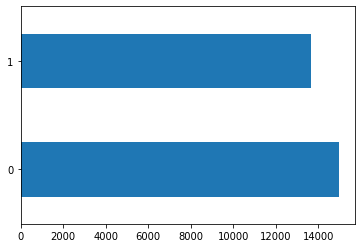

In [8]:
ax = df['is_sarcastic'].value_counts().plot(kind='barh')

## <b> Text Visualization

In [9]:
visualization = DataProcessing.Visualization(df, 'clean text')

### Words Frequency

In [10]:
# words frequency in a dataframe
df_frequency = visualization.words_frequency()

In [11]:
df_frequency[['words', 'freq']].head()

,words,freq
88,trump,1151
79,new,1097
95,man,795
843,says,403
206,one,402


In [12]:
df_frequency[['words', 'freq']].tail()

,words,freq
22085,chaotic,1
22086,houseiran,1
22087,electionburundi,1
22088,keepbeekeeper,1
48810,palacedad,1


###  Word Cloud

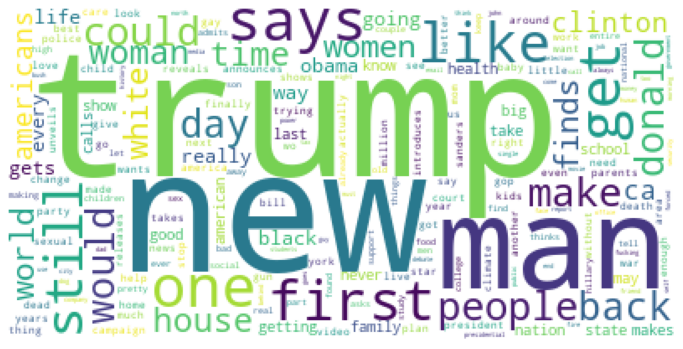

In [13]:
visualization.word_cloud()

### <b>  TDIDF

In [14]:
tf_idf_df = visualization.tf_idf_weights()

tf_idf_df.head()

,TFIDF
lifeinvestigation,12.325378
palling,12.325378
palmsman,12.325378
palpable,12.325378
palsresearchers,12.325378


In [15]:
tf_idf_df.tail()

,TFIDF
like,7.132421
says,7.017111
man,6.338926
new,6.017280
trump,5.969271


Too many misspelled words lead to weighted words

### <b>  Pos Tags

In [16]:
doc = [nlp(sentence) for sentence in df['clean text']]

In [17]:
noun_pos_tags = []
prop_pos_tags = []
verb_pos_tags = []

for text in doc:
    for token in text:        
        if token.pos_ == 'NOUN':
            noun_pos_tags.append(token.text)
        elif token.pos_ == 'PROPN':
            prop_pos_tags.append(token.text)
        elif token.pos_ == 'VERB':
            verb_pos_tags.append(token.text)            

In [18]:
len(noun_pos_tags), len(prop_pos_tags), len(verb_pos_tags)

(67372, 54983, 38658)

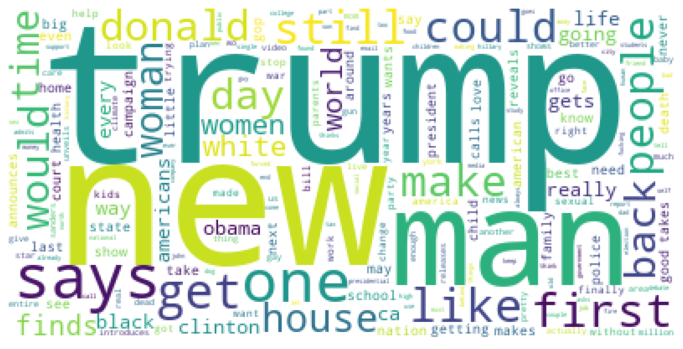

In [19]:
visualization.word_cloud(noun_pos_tags) 

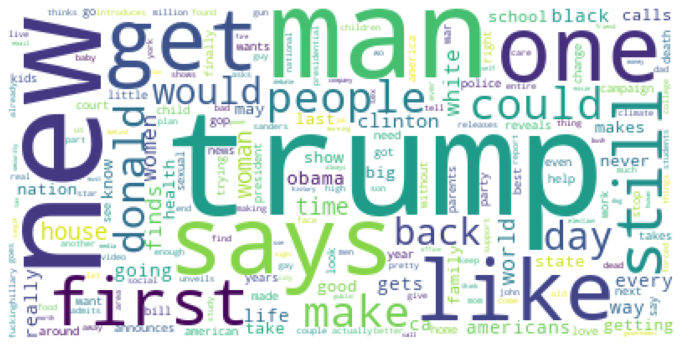

In [20]:
visualization.word_cloud(prop_pos_tags)

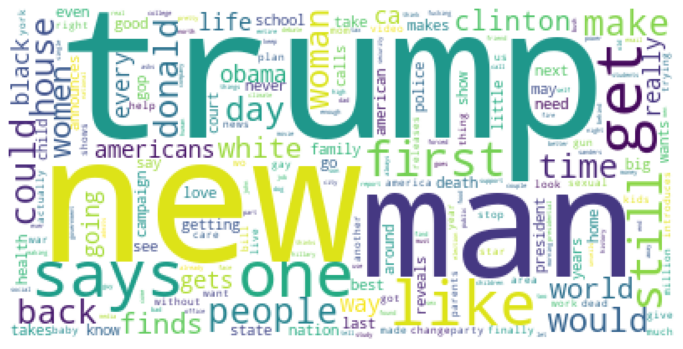

In [21]:
visualization.word_cloud(verb_pos_tags)

# <b> Train a Naive Bayes Classifier

### <b> Configuring parameters

In [59]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
padding_type='post'
oov_tok = "<OOV>"

sentences = df['clean text']
labels = df['is_sarcastic']

In [64]:
sentence_train, sentence_valid, label_train, label_valid = train_test_split(sentences, labels, test_size = 0.3, random_state = 42)
sentence_valid, sentence_test, label_valid, label_test = train_test_split(sentence_valid, label_valid, test_size = 0.3, random_state = 42)

In [65]:
len(sentence_train), len(sentence_valid), len(sentence_test)

(20033, 6010, 2576)

In [66]:
len(label_train),  len(label_valid),  len(label_test)

(20033, 6010, 2576)

### <b> Encoding

In [67]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# build vocabulary
tokenizer.fit_on_texts(sentence_train)
vocabulary = tokenizer.word_index

In [68]:
# Features
train_sequences = tokenizer.texts_to_sequences(sentence_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(sentence_valid)
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(sentence_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [69]:
print("Original sentence = ", sentence_train[0])
print("Tokenized sentence = ", train_sequences[0])
print("Padded sentence = ", train_padded_sequences[0])

Original sentence =  thirtysomething scientists unveil doomsday clock hair loss
Tokenized sentence =  [50, 1, 1, 367, 1, 1, 472]
Padded sentence =  [ 50   1   1 367   1   1 472   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [70]:
len(train_padded_sequences), len(valid_padded_sequences), len(test_padded_sequences)

(20033, 6010, 2576)

### <b> Bidirectional LSTM

In [71]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,  input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 32,769
Trainable params: 32,769
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
num_epochs = 10
history = model.fit(train_padded_sequences, 
                    label_train, 
                    batch_size=2048,
                    epochs=num_epochs, 
                    validation_data=(valid_padded_sequences, label_valid), 
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 5s 370ms/step - loss: 0.6924 - accuracy: 0.5123 - val_loss: 0.6911 - val_accuracy: 0.5153
Epoch 2/10
10/10 [==============================] - 3s 335ms/step - loss: 0.6887 - accuracy: 0.5253 - val_loss: 0.6853 - val_accuracy: 0.5203
Epoch 3/10
10/10 [==============================] - 3s 327ms/step - loss: 0.6793 - accuracy: 0.5509 - val_loss: 0.6699 - val_accuracy: 0.6188
Epoch 4/10
10/10 [==============================] - 3s 337ms/step - loss: 0.6571 - accuracy: 0.6364 - val_loss: 0.6576 - val_accuracy: 0.6135
Epoch 5/10
10/10 [==============================] - 3s 340ms/step - loss: 0.6297 - accuracy: 0.6454 - val_loss: 0.6186 - val_accuracy: 0.6473
Epoch 6/10
10/10 [==============================] - 3s 340ms/step - loss: 0.5955 - accuracy: 0.6797 - val_loss: 0.5872 - val_accuracy: 0.6839
Epoch 7/10
10/10 [==============================] - 4s 355ms/step - loss: 0.5497 - accuracy: 0.7194 - val_loss: 0.5560 - val_accuracy: 0.7097
Epoch 

### <b> Metrics

In [75]:
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sea

In [83]:
y_pred = model.predict(test_padded_sequences)
y_pred = np.argmax(y_pred, axis=1)
y_test =  label_test

In [86]:
len(y_pred), len(y_test)

(2576, 2576)

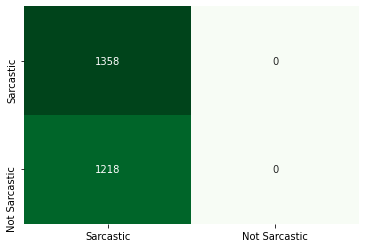

In [88]:
x_y_labels = ['Sarcastic', 'Not Sarcastic']

model_metrics = {
    'accuracy': round(accuracy_score(y_test, y_pred), 3),
    'f1': round(f1_score(y_test, y_pred, average='micro', zero_division=0), 3),
    'recall': round(recall_score(y_test, y_pred, average='micro', zero_division=0),3),
    'precision': round(precision_score(y_test, y_pred, average='micro', zero_division=0),3)

}        
report = classification_report(y_test, y_pred, target_names=x_y_labels, zero_division=0)    
cfm = confusion_matrix(y_test, y_pred)
cf = sea.heatmap(cfm, annot=True, cmap='Greens',  fmt='', cbar=False, xticklabels=x_y_labels, yticklabels=x_y_labels)